### SqueezeNet

Described here: https://towardsdatascience.com/review-squeezenet-image-classification-e7414825581a

In [39]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.utils import plot_model, to_categorical
import tensorflow_model_optimization as tfmot
import requests
import os
import json
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import audiomentations as AA
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image



In [17]:

url = "https://xeno-canto.org/api/2/recordings?query=cnt:%22United%20States%22"  # Replace with the actual URL

# Function to process each recording object
def process_recording(recording):
    return {
        'genus': recording['gen'],
        'species': recording['sp'],
        'name': recording['en'],
        'file': recording['file']
    }

def fetch_data():
    page = 1
    results = []

    while True:
        response = requests.get(url, params={"page": page})
        if response.status_code == 200:
            data = response.json()
            num_pages = int(data["numPages"])
            recordings = data["recordings"]

            # Process each recording object
            results.extend([{
                'genus': recording['gen'],
                'species': recording['sp'],
                'name': recording['en'],
                'file': recording['file'],
                'filename': recording['file-name']
            } for recording in recordings])

            if page == 3: #num_pages:
                break  # Exit the loop if all pages have been fetched

            page += 1  # Increment page for the next request
        else:
            print("Error:", response.status_code)
            break  # Stop fetching data in case of an error
    return results

call_recordings = fetch_data()


In [23]:
def download_files(results, subdirectory):
    os.makedirs(subdirectory, exist_ok=True)  # Create subdirectory if it doesn't exist

    for result in results:
        file_url = result['file']
        filename = result['filename']
        file_path = os.path.join(subdirectory, filename)  # Construct the file path

        # Download and save the file
        response = requests.get(file_url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
                print(f"File '{filename}' downloaded successfully.")
        else:
            print(f"Failed to download file '{filename}'. Status code: {response.status_code}")

        # Save metadata as a separate JSON file
        metadata_filename = f"{filename}.json"
        metadata_path = os.path.join(subdirectory, metadata_filename)
        with open(metadata_path, 'w') as metadata_file:
            json.dump(result, metadata_file, indent=4)
            print(f"Metadata file '{metadata_filename}' saved successfully.")


download_files(call_recordings, 'calls')

File 'XC667363-AK MEGU fc 2230 6-8-2021 nome nk for xc.mp3' downloaded successfully.
Metadata file 'XC667363-AK MEGU fc 2230 6-8-2021 nome nk for xc.mp3.json' saved successfully.
File 'XC664303-AK MEGU ad fc Elim 2021-6-8 1021 Nome nk for xc.mp3' downloaded successfully.
Metadata file 'XC664303-AK MEGU ad fc Elim 2021-6-8 1021 Nome nk for xc.mp3.json' saved successfully.
File 'XC384977-Mew Gull adult, flt end -CA, Ferndale Bottoms, Humboldt County, January 27, 2017, 0446 PM.mp3' downloaded successfully.
Metadata file 'XC384977-Mew Gull adult, flt end -CA, Ferndale Bottoms, Humboldt County, January 27, 2017, 0446 PM.mp3.json' saved successfully.
File 'XC322879-LS_52136 Mew Gull calls A.mp3' downloaded successfully.
Metadata file 'XC322879-LS_52136 Mew Gull calls A.mp3.json' saved successfully.
File 'XC322828-LS_52069 Mew Gull call A.mp3' downloaded successfully.
Metadata file 'XC322828-LS_52069 Mew Gull call A.mp3.json' saved successfully.
File 'XC189389-Mew Gull_chick2014-7-8-4.mp3' do

ChunkedEncodingError: ("Connection broken: ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None)", ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [42]:
def load_data(directory, test_size=0.2, random_state=42):
    filenames = []
    labels = []

    target_size = (128, 512)
    
    # Load filenames and labels from metadata JSON files
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            with open(os.path.join(directory, filename)) as metadata_file:
                metadata = json.load(metadata_file)
                filenames.append(metadata['filename'])
                labels.append(f"{metadata['genus']} {metadata['species']}")
    
    # Load and process audio files into MFCCs with data augmentation 
    mfccs = []
    augmentation = AA.Compose([
        AA.AddGaussianNoise(p=0.5),
        AA.PitchShift(p=0.5),
        AA.TimeStretch(p=0.5),
        AA.Shift(p=0.5),
        AA.Normalize(),
    ])

    # Encode labels to integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    
    for filename in filenames:
        audio_path = os.path.join(directory, filename)
        y, sr = librosa.load(audio_path)
        
        # Apply data augmentation
        #augmented_y = augmentation(samples=y, sample_rate=sr)   # this is about 1.75x longer, don't know if it's necessary
        augmented_y = y
        
        # Compute MFCCs
        mfcc =librosa.power_to_db(librosa.feature.melspectrogram(
            np.float32(augmented_y), sr=sr, n_fft=2048, hop_length=512, n_mels=128), ref=np.max)
        # mfcc = librosa.feature.mfcc(y=augmented_y, sr=sr)
        mfcc = Image.fromarray(mfcc).resize(target_size)
        mfccs.append(mfcc)
    
    # Split the data into training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(mfccs, encoded_labels, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test, label_encoder

X_train, X_test, y_train, y_test, label_encoder = load_data('calls')

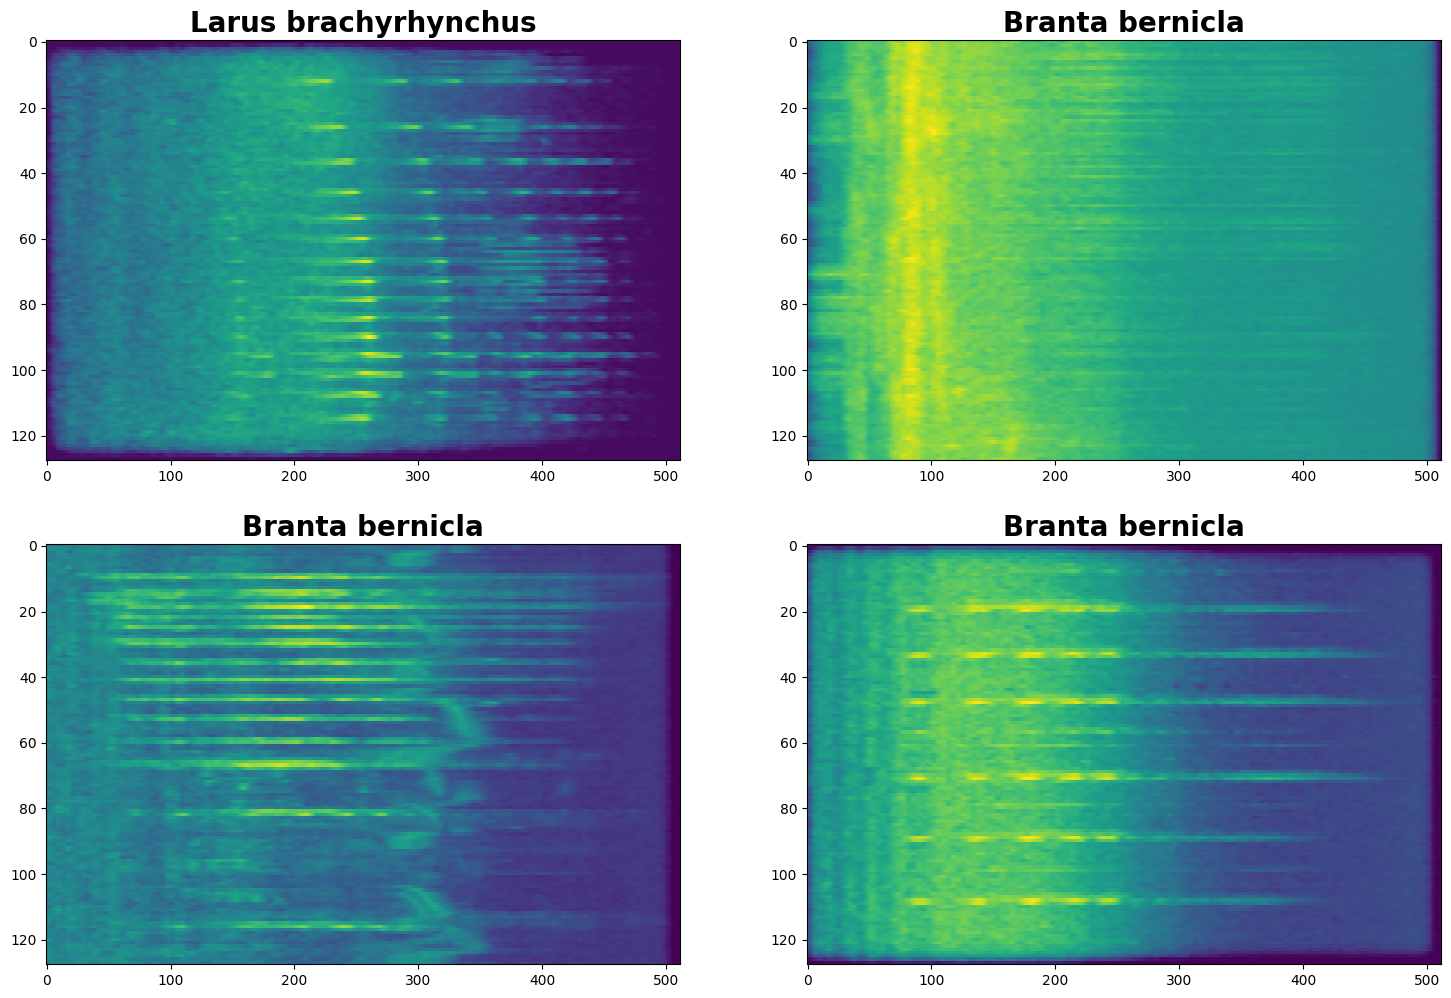

In [43]:
# Plot the figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(np.swapaxes(X_train[0], 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax1.set_title(label_encoder.inverse_transform([y_train[0]])[0], {'fontsize':20, 'fontweight':'bold'})
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.imshow(np.swapaxes(X_train[1], 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax2.set_title(label_encoder.inverse_transform([y_train[1]])[0], {'fontsize':20, 'fontweight':'bold'})
ax2.set_ylim(ax2.get_ylim()[::-1])
ax3.imshow(np.swapaxes(X_train[2], 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax3.set_title(label_encoder.inverse_transform([y_train[2]])[0], {'fontsize':20, 'fontweight':'bold'})
ax3.set_ylim(ax3.get_ylim()[::-1])
ax4.imshow(np.swapaxes(X_train[3], 0 ,1), interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax4.set_title(label_encoder.inverse_transform([y_train[3]])[0], {'fontsize':20, 'fontweight':'bold'})
ax4.set_ylim(ax4.get_ylim()[::-1])
fig.set_size_inches(18,12)

In [44]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    f_id = 'fire' + str(fire_id) + '/'

    # Squeeze
    x = Conv2D(squeeze, (1, 1), padding='valid', name=f_id + 'squeeze1x1')(x)
    x = Activation('relu', name=f_id + 'relu_squeeze1x1')(x)

    # Expand
    left = Conv2D(expand, (1, 1), padding='valid', name=f_id + 'expand1x1')(x)
    left = Activation('relu', name=f_id + 'relu_expand1x1')(left)

    right = Conv2D(expand, (3, 3), padding='same', name=f_id + 'expand3x3')(x)
    right = Activation('relu', name=f_id + 'relu_expand3x3')(right)

    x = Concatenate(axis=-1, name=f_id + 'concat')([left, right])
    return x

def SqueezeNet(input_shape=(224, 224, 3), classes=1000):
    img_input = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)

    x = Conv2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='softmax')(x)

    model = Model(img_input, x, name='squeezenet')

    return model

model = SqueezeNet(input_shape=(128, 512, 1), classes=1000)
model.summary()

Model: "squeezenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 63, 255, 64)  640         ['input_3[0][0]']                
                                                                                                  
 relu_conv1 (Activation)        (None, 63, 255, 64)  0           ['conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 31, 127, 64)  0           ['relu_conv1[0][0]']    

In [45]:
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)


In [46]:
# Add an extra dimension to the spectrogram data
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Add an extra dimension to the spectrogram data
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

c:\Users\ahtam\anaconda3\envs\EE595-lab3\lib\site-packages\numpy\lib\shape_base.py:591: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = asanyarray(a)
c:\Users\ahtam\anaconda3\envs\EE595-lab3\lib\site-packages\numpy\lib\shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


In [47]:


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type Image).

In [6]:
def quantize_model(model, quantization_type, X_train):
    if quantization_type == "drq":
        # Dynamic Range Quantization
        quantized_model = tfmot.quantization.keras.quantize_model(model)
    elif quantization_type == "fiq":
        # Full Integer Quantization
        def representative_dataset_gen():
            for i in range(100):
                yield [X_train[i:i + 1]]
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset_gen
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.int8
        converter.inference_output_type = tf.int8
        converter._experimental_lower_tensor_list_ops = False
        tflite_quant_model = converter.convert()
        quantized_model = clone_model(model)  # This is a workaround to keep the same API for evaluation
        quantized_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    elif quantization_type == "f16q":
        # Float16 Quantization
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
        tflite_quant_model = converter.convert()
        quantized_model = clone_model(model)  # This is a workaround to keep the same API for evaluation
        quantized_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    else:
        raise ValueError("Invalid quantization type")
    return quantized_model
